In [1]:
#import
import logging
import os
import zipfile
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
rootDir = '/content/gdrive/My Drive'
workDir = os.path.join(rootDir, 'AI/kaggle')
trainSetZip = os.path.join(workDir, 'train.zip')
testSetZip = os.path.join(workDir, 'test.zip')
datasetDir = os.path.join(workDir, 'dataset')

In [0]:
os.mkdir(datasetDir)
  

In [0]:
train = zipfile.ZipFile(trainSetZip)
test = zipfile.ZipFile(testSetZip)

In [0]:
train.extractall(datasetDir)
train.close()

In [0]:
test.extractall(datasetDir)
test.close()

In [4]:
import numpy as np
from keras.optimizers import (
                adam,
                rmsprop
)
from keras.models import Sequential
from keras.layers import (
                Conv2D,
                MaxPool2D,
                Dense,
                Dropout,
                Flatten,
                Activation
)
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import backend
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import os
import logging
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Using TensorFlow backend.


In [5]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
class MyModel:
  
    def __init__(self, dataPath, batchSize, imgWidth, imgLength, lr=(1e-4), acct=None, epocs=50, test_size=0.25):
        msg = "Import Below First."
        print(
        f'''{msg}
            import numpy as np
            from keras.optimizers import (
                            adam,
                            rmsprop
            )
            from keras.models import Sequential
            from keras.layers import (
                            Conv2D,
                            MaxPool2D,
                            Dense,
                            Dropout,
                            Flatten,
                            Activation
            )
            from keras.preprocessing.image import ImageDataGenerator
            from keras.utils import to_categorical
            from keras import backend
            from sklearn.preprocessing import LabelEncoder
            from sklearn.model_selection import train_test_split
            import cv2
            import os
            import logging
            import matplotlib.pyplot as plt
            %matplotlib inline
            import seaborn as sns
        '''
        )
        self.lr = lr
        self.epocs = epocs
        if not acct:
            if acct == 'adam':
                self.acct = adam(lr=self.lr, decay=self.lr/self.epocs)
            else:
                self.acct = rmsprop(lr=self.lr, decay=self.lr/self.epocs)
        else:
            self.acct = rmsprop(lr=self.lr)
        
        self.imgWidth = int(imgWidth)
        self.imgLength = int(imgLength)
        self.dataPath = dataPath
        self.batch_size = batchSize
        self.test_size = test_size
    
    def _lableEncoder(self, y):
        lencoder = LabelEncoder()
        y = lencoder.fit_transform(y)
        return y
    
    def _convertToNumpyArray(self, X):
        X = np.array(X)
        return X
    
    def _plotFirstFive(self, X):
        plt.figure(figsize=(20, 10))
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(X[i])
        
    def dataPreprocess(self, datapath):
        X = []
        y = []
        for lable in os.listdir(datapath):
            lablepath = os.path.join(datapath, lable)
            for image in os.listdir(lablepath):
                try:
                    imgpath = os.path.join(lablepath, image)
                    img = cv2.imread(imgpath)
                    img = cv2.resize(img, (self.imgWidth, self.imgLength))
                    X.append(img)
                    y.append(lable)
                except Exception as e:
                    logging.warning(f'Unable to read {image}. ERROR:: {e}')
        
        print('Converting lables to OneHotencoding using LableEncoder.')
        y = self._lableEncoder(y)
        
        print('Converting image/features to numpy array.')
        X = self._convertToNumpyArray(X)
        
        print(f'Shape of X is {X.shape} and y is {y.shape}')
        
        print(f'Type of array X is {type(X)} and y is {type(y)}')
        
        return X, y
    
    def _imageDataGen(self):
        X, y = self.dataPreprocess(self.dataPath)
        self.trainX, self.testx, self.trainY, self.testy = train_test_split(X, y, test_size=self.test_size, random_state=42)
        
        print('Plotting first five images of trainX processed dataset.')
        self._plotFirstFive(self.trainX)
        
        print('Plotting first five images of testx processed dataset.')
        self._plotFirstFive(self.testx)
        
        print(f'Shape of trainX and trainY is {self.trainX.shape}, {self.trainY.shape} respectively.')
        print(f'Shape of testx and testy is {self.testx.shape}, {self.testy.shape} respectively.')
        
        self.trainY = to_categorical(self.trainY, num_classes=12)
        self.testy = to_categorical(self.testy, num_classes=12)
        
        print(f'Shape of trainX and trainY is {self.trainX.shape}, {self.trainY.shape} respectively.')
        print(f'Shape of testx and testy is {self.testx.shape}, {self.testy.shape} respectively.')
        
        trainDataGen = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=30,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest'
                            
        )
        
        testDataGen = ImageDataGenerator(rescale=1./255)
        
        trainGenrator = trainDataGen.flow(self.trainX, self.trainY, batch_size=self.batch_size)
        testGenrator = testDataGen.flow(self.testx, self.testy, batch_size=self.batch_size)
        
        return trainGenrator, testGenrator
        
    
    def model(self):
      
        classifier = Sequential()
        classifier.add(Conv2D(32, (3, 3), input_shape=(self.imgWidth, self.imgLength, 3)))
        classifier.add(Activation('relu'))
        classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

        classifier.add(Conv2D(64, (3, 3)))
        classifier.add(Activation('relu'))
        classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

        classifier.add(Conv2D(128, (3, 3)))
        classifier.add(Activation('relu'))
        classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
        
        classifier.add(Conv2D(128, (3, 3)))
        classifier.add(Activation('relu'))
        classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

        classifier.add(Flatten())
        classifier.add(Dense(512))
        classifier.add(Activation('relu'))
        classifier.add(Dropout(0.3))
        classifier.add(Dense(12))
        classifier.add(Activation('softmax'))
        
        classifier.compile(loss='categorical_crossentropy',
                      optimizer=self.acct,
                      metrics=['accuracy'])
        
        print(classifier.summary())
        
        trainGenrator, testGenrator = self._imageDataGen()
        nTrainSize = len(self.trainX)
        nTestSize = len(self.testy)
        
        hist = classifier.fit_generator(
                    trainGenrator,
                    steps_per_epoch=nTrainSize / self.batch_size,
                    epochs=self.epocs,
                    validation_data=testGenrator,
                    validation_steps=nTestSize / self.batch_size
        )
        
        return hist
    
    def main(self):
        return self.model()

In [0]:
datasetPath = os.path.join(datasetDir, 'train')
batchSize = 32
imgwidth = 128
imglength = 128
lr = (1e-3)
acct = 'adam'
epocs = 75

In [13]:
mod = MyModel(
        dataPath=datasetPath,
        batchSize=batchSize,  
        imgWidth=imgwidth, 
        imgLength=imglength, 
        lr=lr,
        acct=acct,
        epocs=epocs
)

Import Below First.
            import numpy as np
            from keras.optimizers import (
                            adam,
                            rmsprop
            )
            from keras.models import Sequential
            from keras.layers import (
                            Conv2D,
                            MaxPool2D,
                            Dense,
                            Dropout,
                            Flatten,
                            Activation
            )
            from keras.preprocessing.image import ImageDataGenerator
            from keras.utils import to_categorical
            from keras import backend
            from sklearn.preprocessing import LabelEncoder
            from sklearn.model_selection import train_test_split
            import cv2
            import os
            import logging
            import matplotlib.pyplot as plt
            %matplotlib inline
            import seaborn as sns
        


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
__________

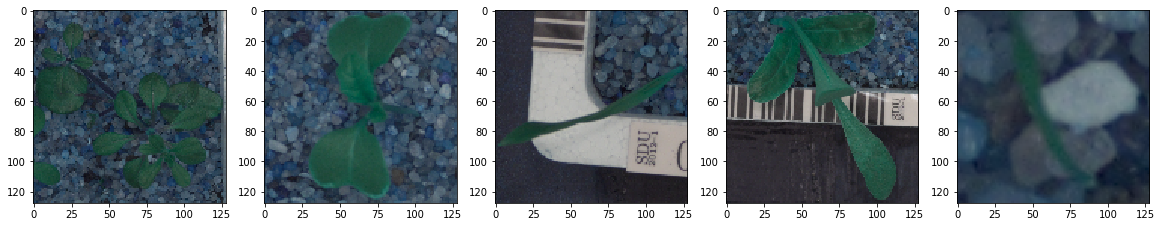

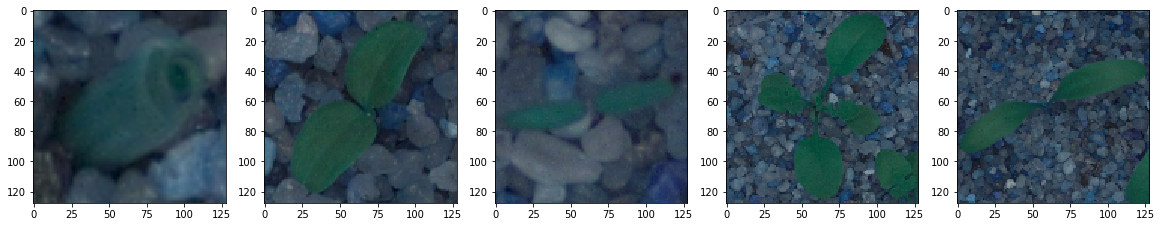

In [14]:
adamModel = mod.main()

In [0]:
adamModel.model.save_weights(os.path.join(workDir, 'adam_model_weights_75.h5'))
adamModel.model.save(os.path.join(workDir, 'adam_keras_75.h5'))

In [0]:
#read the test data.
testDataPath = os.path.join(workDir, 'dataset/test')


def redTestData(testDataPath):
    X = []
    for image in os.listdir(testDataPath):
        imgpath = os.path.join(testDataPath, image)
        try:
            img = cv2.imread(imgpath)
            img = cv2.resize(img, (128, 128))
            X.append(img)
        except Exception as e:
            logging.warning(f'Unable to read {image}. ERROR:: {e}')
    
    X = np.array(X, dtype='float') / 255
    print(f'Shape of X is {X.shape}')
    print(f'Type of array X is {type(X)}')
    
    return X


def plotFirstFive(X):
    plt.figure(figsize=(20, 10))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(X[i])

In [25]:
testX = redTestData(testDataPath)

Shape of X is (794, 128, 128, 3)
Type of array X is <class 'numpy.ndarray'>


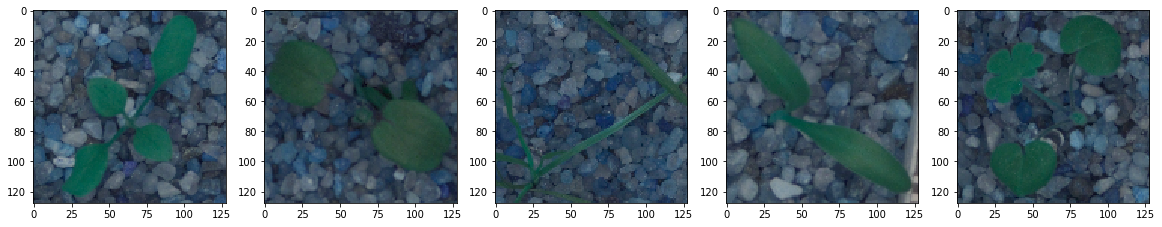

In [26]:
plotFirstFive(testX)

In [27]:
yfit = adamModel.model.predict(testX, batch_size=32, verbose=1)

794/794 [==============================] - 1s 1ms/step


In [30]:
yfit.shape

(794, 12)

In [38]:
adamModel.model.predict_classes(testxX)

array([ 3,  2,  6, 11, 10,  3,  3,  3,  3,  2,  0,  0,  2,  6,  6,  5, 11,
        2,  2,  6, 11,  8,  5,  6,  8,  9,  6,  6,  3, 11,  8,  5,  0,  6,
        3,  6,  3,  6,  6, 11,  7,  3,  2,  6,  8,  6, 11,  6,  3,  5,  2,
        6, 11,  7,  8,  6, 10, 11,  8, 11,  3,  2,  5,  6, 10,  1,  3,  1,
        7,  0,  6,  6,  6,  6,  1, 10,  6,  3,  3,  8,  8,  4, 11,  6,  8,
        3, 11, 11,  6,  4,  1, 11,  3, 10, 10,  7,  5,  5,  3,  5,  9, 10,
        0,  5,  3,  3,  3,  7, 10,  7,  3, 10,  8,  3,  6,  5, 10,  2,  5,
        8,  5,  4,  7,  8,  8, 11, 11,  6,  8,  2,  8,  4,  8,  3,  2, 11,
        1,  6, 11,  6,  8,  0,  8,  8,  4,  3,  6,  5,  9,  2,  3,  8,  2,
        3,  2,  7, 10,  5,  7, 11,  1,  6,  1,  2,  6,  5,  5,  1,  3,  4,
        5,  2, 11, 11,  6,  6,  8, 10, 10, 11,  4,  0, 10,  4,  9,  6,  1,
       11,  5,  4,  6,  6,  5,  3, 10,  1,  3,  6,  2,  9, 10,  3,  8,  8,
        9,  8,  2,  0,  3,  6,  8,  6, 11,  2,  9,  3, 11,  3,  8,  5,  3,
       10, 10,  1,  9, 10